# 주의 사항

- 본 코드는 tensorflow 2.6.0.의 API를 기준으로 작성되었음을 알립니다.
- 세부적인 버전이 상이할 경우 코드 재현이 보장되지 않습니다.

In [1]:
# 버전 정보 체크
import tensorflow as tf
tf.__version__

'2.6.0'

# 아마존 리뷰 데이터셋(예제)

터미널을 열어 아래와 같이 작업환경을 구성

`$ mkdir -p ~/aiffel/news_summarization/data`

사용할 데이터셋 : Kaggle에서 제공된 아마존 리뷰

클라우드에 올라가있는 데이터셋을 사용하려면 다음과 같이 실행

`$ ln -s ~/data/*.csv ~/aiffel/news_summarization/data`

NLTK의 불용어(stopwords)를 사용하여 데이터 전처리
- NTLK와 NLTK 데이터셋이 설치되어 있지 않은 환경이라면 우선 NLTK를 설치하고 NTLK의 데이터셋이 필요

NLTK : Natural Language Toolkit의 축약어 
- *영어 기호, 통계, 자연어 처리*를 위한 라이브러리

> I, my, me, over, 조사, 접미사와 같이 문장에는 자주 등장하지만, 
의미 분석 및 요약에 의미가 없는 *100여개의 불용어가 미리 정리되어* 있음.

In [27]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re

import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from tensorflow import keras
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


링크에서 다운로드 받은 데이터(Reviews.csv)는 총 568,454개의 샘플
- 시간상 여기서는 모든 샘플을 사용하지는 않고, 간단히 10만 개의 샘플만 사용

In [71]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [72]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [42]:
# 실제 사용할 열들만 저장
# Q. 데이터프레임 data의 Text와 Summary 컬럼의 데이터만 남기는 코드를 작성하세요.
data = data.loc[:, ['Summary', 'Text']]
data.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [43]:
#랜덤한 15개 샘플 출력
data.sample(15)

,Summary,Text
5371,Wonderful Product!,"This is a wonderful product, I was happy to se..."
17565,Love this tea- great deal!,I love this tea!!! Im an engineer and seemed t...
40499,Distinct Odor but I Really Like It ..,This tea has a strong pungent smell that my hu...
22445,Lovely flavor!,It's pretty much impossible to find dry whole ...
48703,not so impressed,with my purchase of the tea I was not impresse...
48091,Not my favorite but good for you!,Not sure if I would buy this again- Didn't rea...
91844,A great all purpose rub.,"Terrific authentic jerk flavor, and wont overp..."
25337,Great stuff,I've gotten these from amazon before. I just a...
25261,Life Savers Continues a Great Product,The same great taste! I looked for Life Savers...
53157,"Wow, kibble my dogs actually dance for!","Wheat-free, baby, and so much cheaper than my ..."


이제 데이터를 불러왔으니 전처리를 진행해 볼게요. 빈칸으로 존재하는 null 데이터, 의미는 같지만 다른 식으로 작성된 글 같은 중복 항목과 같은 학습할 때 방해가 되는 데이터를 먼저 솎아낼 거예요.

## 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [44]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


중복을 제외한다면 Text에는 88,426개, Summary에는 72,348개의 유니크한 데이터가 존재해요. 사실 이 데이터의 Summary는 'Smelly'나 'Good Product'와 같이 아주 간단한 요약들도 많아서 Text가 달라도 Summary는 동일할 수 있어요. 하지만 Text 자체가 중복이 된 경우는 중복 샘플이므로 제거해야겠죠.

데이터프레임의 drop_duplicates()를 사용하면, 손쉽게 중복 샘플을 제거할 수 있어요.

In [45]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


중복이 제거되면서 샘플 수가 88,426개로 줄어들었어요. 그런데 만약 데이터 Null 값을 가지는 샘플이 있었다면, drop_duplicates()가 중복된 Null들을 지워주기는 하겠지만, 여전히 Null 값 한 개가 어딘가 남아있을 수 있어요. 데이터에 Null 값이 남아있는지 볼게요.

데이터프레임에 Null 값이 있는지 확인하는 방법은 .isnull().sum()을 사용하면 알아볼 수 있어요.

In [46]:
print(data.isnull().sum())

Summary    1
Text       0
dtype: int64


Summary에 1개의 Null 값이 있네요. 데이터프레임에서 Null을 제거할 때는 dropna() 함수를 사용하면 돼요.

In [47]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


전체 샘플 수가 1개 줄어들어 88,425개의 샘플이 남았네요. 지금까지 중복 샘플과 Null 값이 있는 샘플들을 제거해보았는데 10만 개의 샘플 중 1만 개 이상의 샘플이 제거되었어요.

### 텍스트 정규화와 불용어 제거
살아남은 88,425개의 샘플에는 수많은 단어들이 있어요. 그런데 사실 그 단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있어요.

예를 들어서 it'll은 it will과 같고, mustn't과 must not은 사실 같은 표현이죠. 이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법이에요.

이러한 방법론을 텍스트 처리에서는 텍스트 정규화(text normalization) 라고 해요.

여기서는 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성할 거예요. 이 사전은 아래의 링크에서 참고하여 만들었어요.

[정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [48]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


이제 정규화 준비까지 마쳤어요.

하지만 아직 끝난 게 아니에요. 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재해요. 이를 불용어(stopwords)라고 불러요. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있어요. 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거할 거예요.

In [49]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개라는 것을 볼 수 있죠. 이를 사용하여 불용어를 제거할 거예요. 이 작업 외에도 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리할 거예요.

함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정이에요. Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는 게 더 좋을 것 같습니다. 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가했어요.






In [50]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [51]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, <br />과 같은 html 태그가 제거되었죠. (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있어요. 또한 특수문자가 제거되면서 영어만 남았어요.

이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행해볼게요. 이때, Text의 경우에는 불용어를 제거하고, Summary의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 해요. 먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해볼게요.

Q. 위의 내용을 참고해서 훈련 데이터 전체의 Text 컬럼의 데이터를 전처리하는 코드를 작성하세요.(반복문 사용)

In [52]:
# # 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
# clean_text = []

# for _sentence in data['Text'] : 
#     clean_text.append(preprocess_sentence(_sentence))


# # 전처리 후 출력
# print("Text 전처리 후 결과: ", clean_text[:5])

In [ ]:
# 성연님의 코드리뷰 후 참고해서 한번 적용을 해봤는데, 앞서 내가 적용했던 것과 시간면에서 차이가 없었음.
# from tqdm import tqdm, trange
# tqdm.pandas()

# clean_text = data['Text'].progress_apply(lambda x: preprocess_sentence(x)).tolist()

# # 전처리 후 출력
# print("Text 전처리 후 결과: ", clean_text[:5])


53%|█████▎    | 46628/88425 [05:59<05:22, 129.61it/s] # 11분은 걸릴 것 같고, 나도 이정도 걸림

부정을 나타내는 not과 관련한 것들이 불용어에 많이 있음. 영향이 없을까..?

이제 Summary에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣어줄게요.

Q. 위의 내용을 참고해서 훈련 데이터 전체의 Summary 컬럼의 데이터를 전처리하는 코드를 작성하세요.(반복문 사용)

In [ ]:
# # 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
# clean_summary = []

# for _sentence in data['Summary'] : 
#     clean_text.append(preprocess_sentence(_sentence, False))


# print("Summary 전처리 후 결과: ", clean_summary[:5])

이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋아요. 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있어요. 이렇게 되면 샘플 자체가 빈 값을 가지게 되겠죠.

보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장할게요. 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체해요.

In [14]:
%%time
data['Text'] = data['Text'].map(preprocess_sentence)

CPU times: user 9min 37s, sys: 1min 45s, total: 11min 22s
Wall time: 11min 23s


In [15]:
data['Text'].head()

0    bought several vitality canned dog food produc...
1    product arrived labeled jumbo salted peanuts p...
2    confection around centuries light pillowy citr...
3    looking secret ingredient robitussin believe f...
4    great taffy great price wide assortment yummy ...
Name: Text, dtype: object

In [16]:
%%time
data['Summary'] = data['Summary'].map(lambda x: preprocess_sentence(x, False))

CPU times: user 13.7 s, sys: 385 ms, total: 14.1 s
Wall time: 14.1 s


In [17]:
data['Summary'].head()

0    good quality dog food
1        not as advertised
2      delight says it all
3           cough medicine
4              great taffy
Name: Summary, dtype: object

In [56]:
# data['Text'] = clean_text
# data['Summary'] = clean_summary

In [19]:
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

이전과 같이 .isnull().sum()을 사용해서 Null 값이 생겼는지 해볼게요.

In [20]:
data.isnull().sum()

Summary    70
Text        0
dtype: int64

Summary 열에서 70개의 Null 값이 생겼네요. 원래는 단어가 있었는데, 정제 과정에서 모든 단어가 제거되어 빈 샘플이 70개나 생겼다는 의미예요. 이 샘플들은 모두 제거해줄게요.

In [21]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시해 줘야 해요.

### 샘플의 최대 길이 정하기

필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례에요.

Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 볼게요.

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


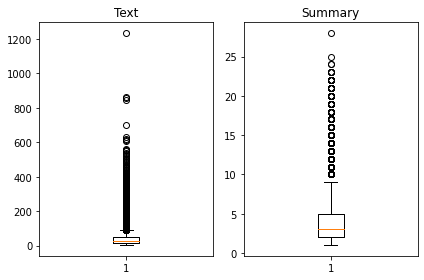

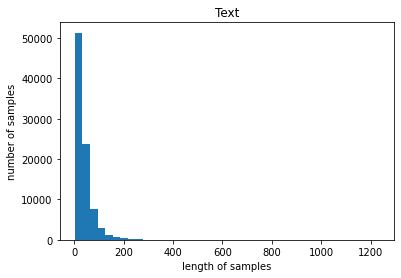

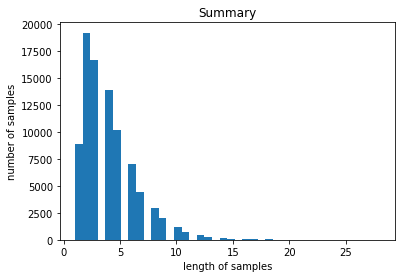

In [22]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프처럼, 많은 양의 데이터를 다룰 때는 데이터를 시각화하여 보는 것이 도움이 돼요. 위에서부터 차례대로 그래프는 각각 실제 텍스트와 요약의 길이 분포, 실제 텍스트 샘플 길이별 개수, 요약본 샘플 길이별 개수를 나타내고 있어요.

Text의 경우 최소 길이가 2, 최대 길이가 1,235로 그 차이가 굉장히 크죠. 하지만 평균 길이는 38로 시각화된 그래프로 봤을 때는 대체적으로는 100 내외의 길이를 가진다는 것을 확인할 수 있어요.

Summary의 경우 최소 길이가 1, 최대 길이가 28, 그리고 평균 길이가 4로 Text에 비해 상대적으로 길이가 매우 짧아요. 그래프로 봤을 때에도 대체적으로 10이하의 길이를 가지고 있네요.

이로부터 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정해볼게요.

In [19]:
text_max_len = 50
summary_max_len = 8

> 각각 50과 8로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 될거예요. 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해볼게요.

In [24]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

이렇게 만든 함수를 Text와 Summary에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있겠죠.

In [25]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


각각 50과 8로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, Text 열의 경우에는 약 23%의 샘플들이 내용이 망가지게 된다고 하네요.

우리는 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제할게요.

#### Q. Text와 Summary를 담고 있는 data 데이터프레임을 위에서 임의로 정의한 text_max_len과 summary_max_len의 길이보다 큰 샘플을 제외하는 코드를 작성하세요.
(힌트 : apply 함수와 lamda식을 사용)

 <span style="color:blue">***이거 작성하다가 data변수 overwriting해서 원본 날라감
전처리 다시 12분 걸려서 진행*** </span>
 

In [26]:
import copy

data_cp = data.copy()

In [27]:
id(data)

135484618981328

In [28]:
id(data_cp)

135481842208288

In [29]:
# Summary를 담고 있는 Text와 data 데이터프레임을 
# 위에서 임의로 정의한 text_max_len과 summary_max_len의 길이보다 
# 큰 샘플을 제외하는 코드

In [30]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)] 
# 68432
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)] 
# 65818
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


### 시작 토큰과 종료 토큰 추가하기
앞서 시작 토큰과 종료 토큰에 대해서 언급했던 것을 기억하시나요? 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 거였죠.

시작 토큰과 종료 토큰 추가하기
앞서 시작 토큰과 종료 토큰에 대해서 언급했던 것을 기억하시나요? 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 거였죠.

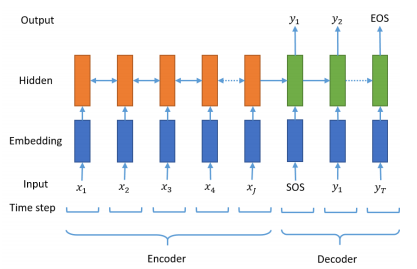content img
[시작 토큰 SOS와 종료 토큰 EOS는 각각 start of a sequence와 end of a sequence를 나타낸다]
https://arxiv.org/pdf/1812.02303.pdf

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있어요. 이번 실습에서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 거예요. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했어요. 두 개의 문장 모두 Summary 열로부터 만들 거예요.






In [31]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,decoder_input,decoder_target
0,good quality dog food,bought several vitality canned dog food produc...,sostoken good quality dog food,good quality dog food eostoken
1,not as advertised,product arrived labeled jumbo salted peanuts p...,sostoken not as advertised,not as advertised eostoken
2,delight says it all,confection around centuries light pillowy citr...,sostoken delight says it all,delight says it all eostoken
3,cough medicine,looking secret ingredient robitussin believe f...,sostoken cough medicine,cough medicine eostoken
4,great taffy,great taffy great price wide assortment yummy ...,sostoken great taffy,great taffy eostoken


앞뒤로 토큰이 잘 붙었죠? 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 줄게요.

---

In [36]:
# 전처리 완료 된 데이터를 저장
# data.to_pickle('./data_preprocessed.pkl')

In [73]:
# 중간에 세션이 끊길 경우, 전처리 데이터를 불러와서 사용한다.
data = pd.read_pickle('./data_preprocessed.pkl')
data

,Summary,Text,decoder_input,decoder_target
0,good quality dog food,bought several vitality canned dog food produc...,sostoken good quality dog food,good quality dog food eostoken
1,not as advertised,product arrived labeled jumbo salted peanuts p...,sostoken not as advertised,not as advertised eostoken
2,delight says it all,confection around centuries light pillowy citr...,sostoken delight says it all,delight says it all eostoken
3,cough medicine,looking secret ingredient robitussin believe f...,sostoken cough medicine,cough medicine eostoken
4,great taffy,great taffy great price wide assortment yummy ...,sostoken great taffy,great taffy eostoken
...,...,...,...,...
99993,great stuff,stuff awesome best flavor boil water drain wat...,sostoken great stuff,great stuff eostoken
99994,good stuff,love noodle little spicy wife perfct,sostoken good stuff,good stuff eostoken
99995,yummy,love buy another box done last one,sostoken yummy,yummy eostoken
99997,great ramen,favorite brand korean ramen spicy used eating ...,sostoken great ramen,great ramen eostoken


---

In [74]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

이제 훈련 데이터와 테스트 데이터를 분리할거에요.

훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법, 또는 직접 코딩을 통해서 분리하는 방법 등 여러 가지 방법이 있을 텐데 여기서는 직접 해볼게요. 우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줄게요.

In [75]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[22301 47370  6991 ... 22463 17905 29771]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 되겠죠.

In [76]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줄게요. 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해 줄게요.

In [77]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분할게요.
:표시의 위치에 주의해 주세요.

In [78]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


훈련 데이터와 테스트 데이터가 각각 52,655개와 13,163개로 잘 분리된 것을 볼 수 있어요!

### 단어 집합(vocabulary) 만들기 및 정수 인코딩

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 해요. 이를 위해서는 <span style="color:blue">각 단어에 고유한 정수를 맵핑하는 작업</span>이 필요해요. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현해요. 훈련 데이터에 대해서 단어 집합을 만들어볼게요. 우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들게요.

<span style="color:blue">**Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요.**</span>

In [79]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있어요. 그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, <span style="color:blue">빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 해요.</span>

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 *얼만큼의 비중을 차지하는지* 확인해볼게요.

<span style="color:blue">src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있어요.

In [80]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31921
등장 빈도가 6번 이하인 희귀 단어의 수: 23698
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8223
단어 집합에서 희귀 단어의 비율: 74.2395288368159
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.38733269025868


In [81]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요. 
<span style="color:blue"> 현재 단어 집합의 크기를 8,000으로 제한했으니까 이제 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않아요.

In [82]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[577, 2374, 2130, 473, 7, 4, 33, 25, 28, 2808, 112, 7, 2247, 4, 552, 294], [8, 15, 671, 1289, 160, 11, 8, 2, 5, 160, 1199, 53, 419, 8, 68, 5102, 11, 8, 37, 419], [439, 776, 93, 179, 640, 382, 407, 39, 23, 14, 508, 34, 543, 54, 72, 2440, 640, 439, 640, 15, 10, 74, 54, 5890, 640, 382, 12, 28, 151, 431, 8, 640, 270, 68, 676, 306, 602, 65, 599, 640, 382, 138, 17, 45, 20]]


이제 더 이상 텍스트 데이터가 아니라 정수가 나오고 있어요.

Summary 데이터에 대해서도 동일한 작업을 수행할게요. 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산해요.

In [83]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 이는 tar_tokenizer.word_index에 저장되어 있어요. tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻어서, <span style="color:blue"> 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지</span> 확인해볼게요.


In [84]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10461
등장 빈도가 5번 이하인 희귀 단어의 수: 8074
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2387
단어 집합에서 희귀 단어의 비율: 77.18191377497371
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.868004378593161


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지하고 있네요.   
하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.87%밖에 되지 않아요.   
아까 했던 것과 동일하게 이 단어들은 모두 제거할게요. 어림잡아 2,000을 단어 집합의 크기로 제한할게요. 

In [85]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1369], [1, 196, 119, 403, 59, 20, 4], [1, 7, 399, 326, 33, 428], [1, 20, 152], [1, 152]]
target
decoder  [[1369, 2], [196, 119, 403, 59, 20, 4, 2], [7, 399, 326, 33, 428, 2], [20, 152, 2], [152, 2]]


정상적으로 정수 인코딩 작업이 끝났어요. 현재 decoder_input_train과 decoder_target_train에는 더 이상 숫자 2,000이 넘는 숫자들은 존재하지 않아요. 그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있어요.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, <span style="color:blue">애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.</span>

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요. 
그래서 이제 길이가 0이 된 요약문의 <span style="color:blue">실제 길이는 1로 나올</span> 거예요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요.

훈련 데이터와 테스트 데이터에 대해서 <span style="color:blue"> 요약문의 길이가 1인 경우</span>의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 거예요.






In [86]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1274
삭제할 테스트 데이터의 개수 : 357
훈련 데이터의 개수 : 51381
훈련 레이블의 개수 : 51381
테스트 데이터의 개수 : 12806
테스트 레이블의 개수 : 12806


훈련 데이터와 테스트 데이터 모두 일정량의 샘플들이 제거된 것을 확인할 수 있어요. 이제 거의 다 왔어요.

### 패딩하기

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요. 아까 정해두었던 최대 길이로 패딩 해 줄 거에요. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [87]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

### 모델 설계하기
이제는 모델을 설계할 시간이에요. 우선 함수형 API를 이용해서 인코더를 설계해 볼게요.

#### Q.인코더 LSTM 1을 참고해서 나머지 인코더의 LSTM 2, LSTM 3의 코드를 완성하세요.

In [88]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했어요. <span style="color:blue"> hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지</span>를 정하는 파라미터에요. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 돼요. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니에요.

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야겠죠?

또한 LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용할 수 있어요. 
일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법이에요.

반면 recurrent dropout은 dropout을 레이어가 아닌 <span style="color:blue">time step마다</span> 해주는 방식이에요.  
즉 time step의 입력을 랜덤으로 생략해 주는 거죠. recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다고 해요.

아래 그림은 일반적인 dropout과, dropout과 recurrent dropout을 동시에 사용한 것을 시각적으로 표현한 것입니다. 색이 있는 화살표는 dropout을 나타낸 것이에요. (색이 다른 것은 다른 dropout mask를 사용했다는 표시인데, 지금은 그냥 넘어가셔도 됩니다.) 코드를 수정해서 LSTM에 dropout과 recurrent dropout을 모두 사용할 수 있습니다. 그렇게 되면 오른쪽 그림과 같은 형태가 되겠군요. 참고로 dropout과 recurrent dropout을 <span style="color:blue"> 모두 사용한 것을 Variational Dropout</span>이라고도 해요.

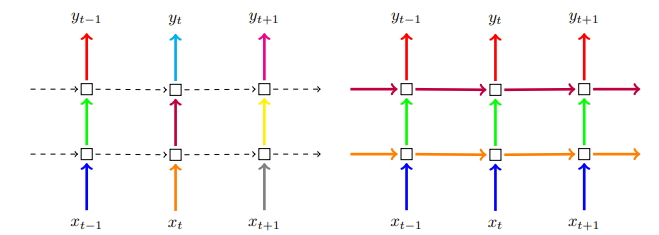
[dropout(왼쪽)과 dropout + recurrent dropout(오른쪽)]

https://arxiv.org/pdf/1512.05287.pdf
참고로 recurrent dropout을 사용하면 아래와 같은 경고문이 뜹니다.

WARNING:tensorflow:Layer lstm_15 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU

recurrent dropout을 사용할 시 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸립니다.

recurrent dropout에 대한 자세한 내용은 아래의 논문을 참고하세요.

[Recurrent Dropout without Memory Loss](https://arxiv.org/pdf/1603.05118v2.pdf)

이제 디코더를 설계해볼게요!

In [89]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일해요. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 해요.

디코더의 출력층을 설계해볼게요.

In [90]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 50, 128)      1024000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 50, 256), (N 394240      embedding_6[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

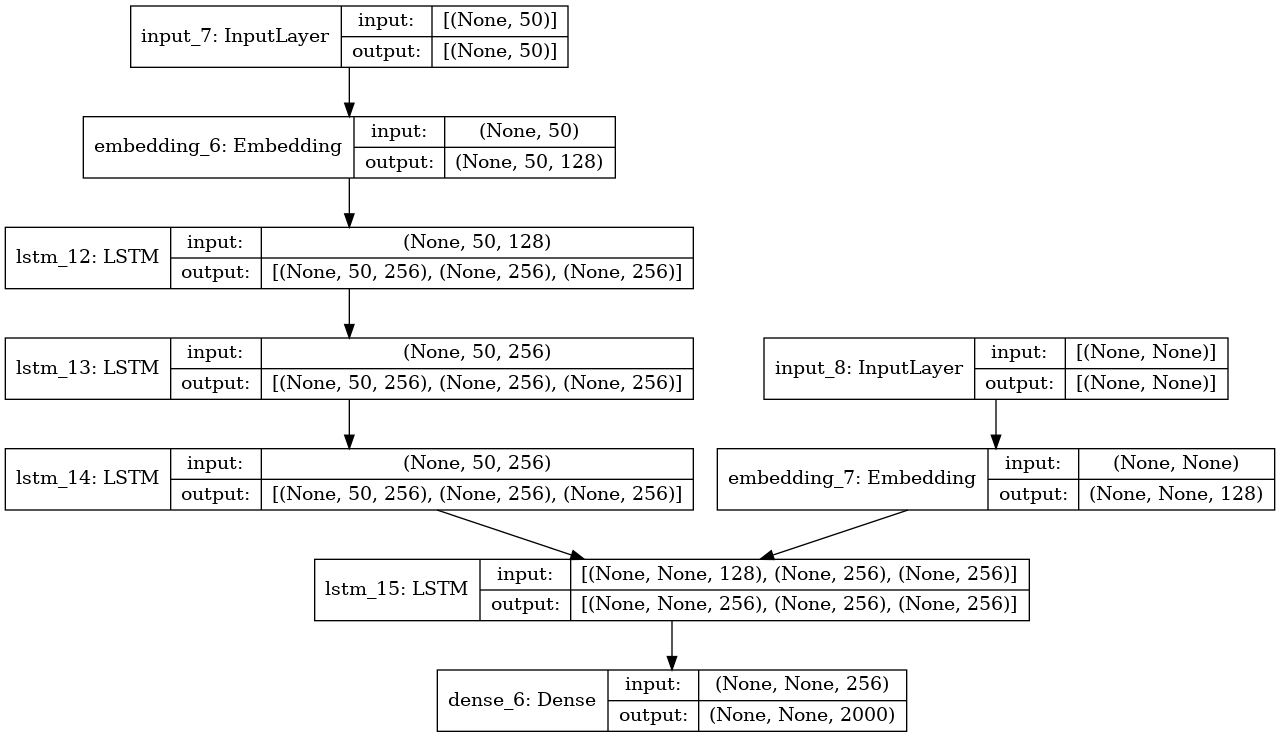

In [91]:
# 모델 확인하기
keras.utils.plot_model(model, show_shapes=True)

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 해요. 
그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있어요.

지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq에요. 그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있어요! 바로 어텐션 메커니즘이에요.

### 어텐션 메커니즘

어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻이에요. 어텐션 함수를 설계해보는 것은 다음 기회로 미루기로 하고, 여기서는 TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워볼게요. 참고로 여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션입니다. 이 어텐션에 대한 자세한 설명은 텐서플로우 홈페이지를 참고하세요.

아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해 봅시다.

In [92]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 50, 128)      1024000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 50, 256), (N 394240      embedding_6[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있어요.

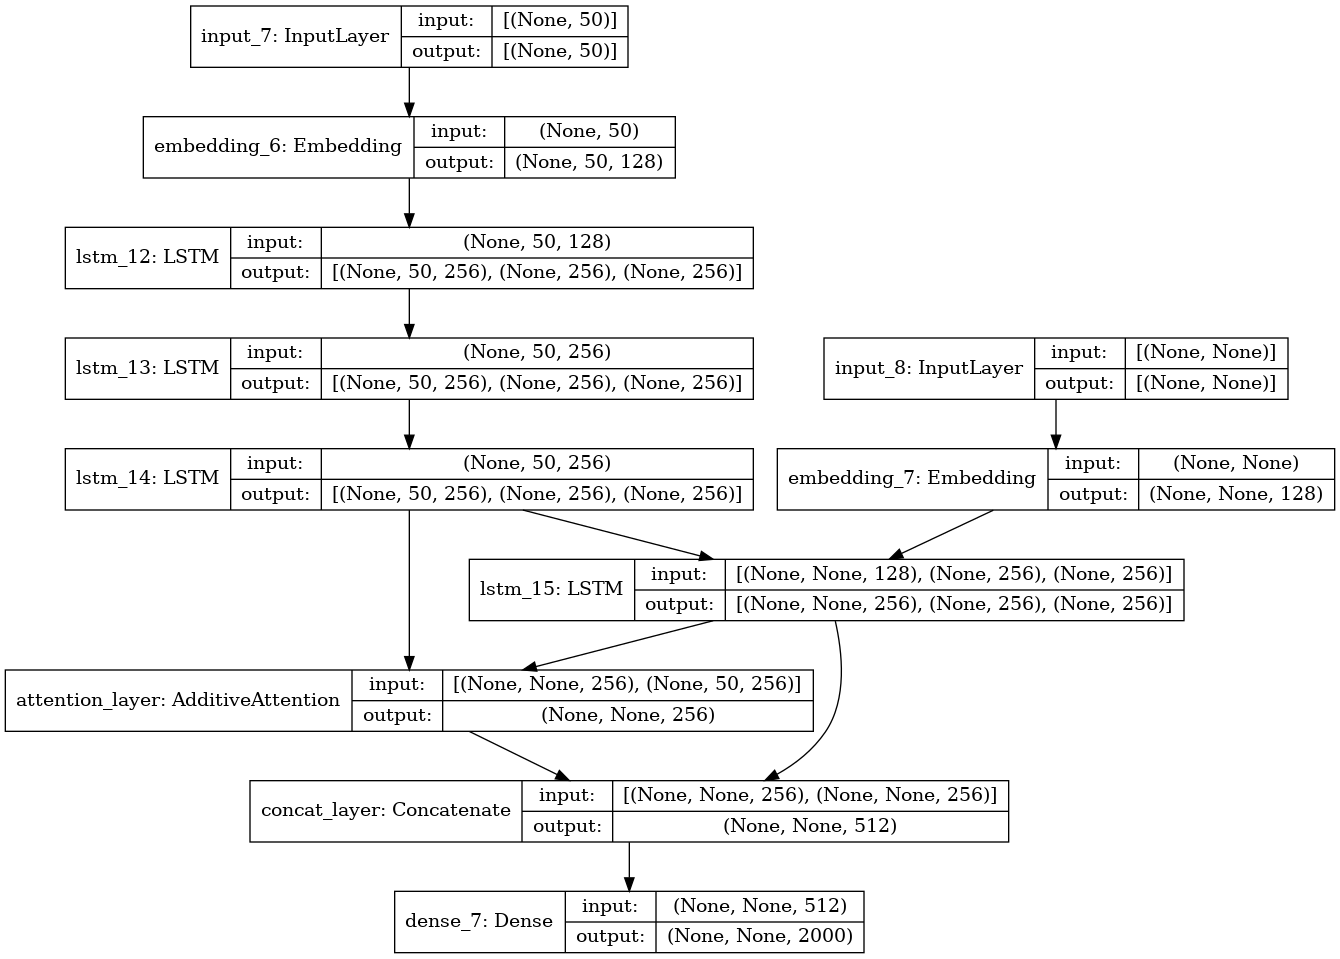

In [93]:
# 완성된 모델의 개념도 확인
keras.utils.plot_model(model, show_shapes=True)

- 왼쪽 위의 3개의 LSTM(input_3에서 lstm_6)까지 Encoder에 해당
- 오른쪽의 input_4부터 lstm_7까지가 Decoder에 해당하며, Decoder의 임베딩과 Encoder의 cell_state, hidden_state를 활용해서 계산된 값을 Encoder와 AdditiveAttention(Badanauh Attention)을 활용하여 최종적으로 Concatenate를 하고, Dense layer를 통해서 다음에 나올 토큰의 최종 확률 결과를 도출합니다.

## 모델 훈련하기
설계한 모델을 가지고 훈련을 진행해볼게요.

In [95]:
# model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
#           validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
#           batch_size=256, callbacks=[es], epochs=50)

In [94]:
%%time
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

checkpoint_filepath = os.getcwd() + './ckpt/summary_checkpoint.model.keras'
# print(checkpoint_filepath)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
        #   batch_size=256,
          batch_size=4096, 
          callbacks=[es, model_checkpoint_callback], epochs=50)


Epoch 1/50
13/13 [==============================] - 47s 1000ms/step - loss: 4.0302 - val_loss: 3.0420
Epoch 2/50
13/13 [==============================] - 12s 910ms/step - loss: 2.9797 - val_loss: 2.9118
Epoch 3/50
13/13 [==============================] - 12s 917ms/step - loss: 2.8451 - val_loss: 2.7414
Epoch 4/50
13/13 [==============================] - 12s 936ms/step - loss: 2.7032 - val_loss: 2.6266
Epoch 5/50
13/13 [==============================] - 12s 940ms/step - loss: 2.6204 - val_loss: 2.5913
Epoch 6/50
13/13 [==============================] - 12s 926ms/step - loss: 2.5809 - val_loss: 2.5550
Epoch 7/50
13/13 [==============================] - 12s 925ms/step - loss: 2.5489 - val_loss: 2.5238
Epoch 8/50
13/13 [==============================] - 12s 919ms/step - loss: 2.5093 - val_loss: 2.4895
Epoch 9/50
13/13 [==============================] - 12s 915ms/step - loss: 2.4771 - val_loss: 2.4576
Epoch 10/50
13/13 [==============================] - 12s 933ms/step - loss: 2.4452 - val_l

'조기 종료'를 뜻하는 EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할을 해요.

> es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)


위 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정돼 있어요. EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있겠네요.

EarlyStopping에 대한 자세한 내용은 아래 링크를 참고하세요! 자주 쓰이는 도구이니 자세히 알아두면 매우 도움이 될 거예요!!

[Early Stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

### Q. Early Stopping을 사용할 경우 조심해야 하는 경우가 있는데, 어떤 경우일까요?

patience가 0이 아닌 경우에는 훈련이 종료되었을 때 성능이 최고인 상황이 아닐 수 있습니다. 예를들어 patience가 3인 경우, 15 epoch에서 loss가 감소하다가 16 epoch부터 loss가 증가한다면 18 epoch 때 모델을 저장하고 학습을 종료합니다. 
> 그래서 학습 중에 모델을 저장하는 callback 함수를 같이 사용한다.


이제 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 해봐요.

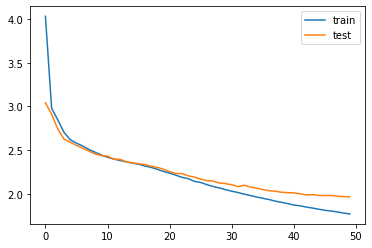

In [109]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

10분간 돌았고, Early stop을 적용했지만 50epoch을 다 돌았다. 확실한 Saturation을 위해서 50번 더 돌려봐야 할 것 같다.

In [111]:
# 모델 체크포인트 저장
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [118]:
# 50에폭 추가로 학습 진행하기
new_model = keras.models.load_model('saved_model/my_model')
new_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 50, 128)      1024000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 50, 256), (N 394240      embedding_6[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [119]:
history = new_model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
        #   batch_size=256,
          batch_size=4096, 
          callbacks=[es, model_checkpoint_callback], epochs=50)

Epoch 1/50
13/13 [==============================] - 18s 1s/step - loss: 1.8030 - val_loss: 1.9565
Epoch 2/50
13/13 [==============================] - 12s 933ms/step - loss: 1.7523 - val_loss: 1.9522
Epoch 3/50
13/13 [==============================] - 12s 940ms/step - loss: 1.7421 - val_loss: 1.9551
Epoch 4/50
13/13 [==============================] - 12s 929ms/step - loss: 1.7317 - val_loss: 1.9550
Epoch 5/50
13/13 [==============================] - 12s 925ms/step - loss: 1.7193 - val_loss: 1.9481
Epoch 6/50
13/13 [==============================] - 12s 920ms/step - loss: 1.7096 - val_loss: 1.9423
Epoch 7/50
13/13 [==============================] - 12s 920ms/step - loss: 1.7027 - val_loss: 1.9440
Epoch 8/50
13/13 [==============================] - 12s 926ms/step - loss: 1.6920 - val_loss: 1.9405
Epoch 9/50
13/13 [==============================] - 12s 922ms/step - loss: 1.6823 - val_loss: 1.9478
Epoch 10/50
13/13 [==============================] - 12s 927ms/step - loss: 1.6730 - val_loss:

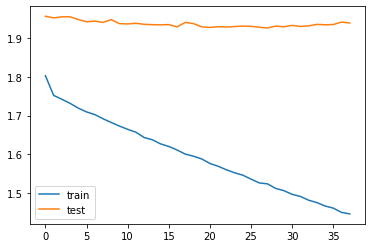

In [120]:
# 38에폭 추가 학습 후 플롯
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- 추가학습이 된 것이 점점 Overfit이 되는 경향을 확인.
- val_loss기준으로 1.94정도가 되는 에폭이 적절한 성능에 해당할 것 같다.

In [121]:
new_model.save('saved_model/my_model_100epochs')

INFO:tensorflow:Assets written to: saved_model/my_model_100epochs/assets


INFO:tensorflow:Assets written to: saved_model/my_model_100epochs/assets


## 인퍼런스 모델 구현하기

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를   
<span style="color:blue"> 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비</span>해 둡니다.

In [123]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련할 때와 <span style="color:blue"> 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다</span>는 것, 알고 계시나요?

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 <span style="color:red"> 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를</span> 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [124]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


어텐션 메커니즘을 사용하는 출력층을 설계해 주세요.

In [125]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))

attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input]) # 2개 입력 시 : query, value = key
# decoder의 hidden상태가 key, val로 사용되고, 출력값이 query로 사용
# Additive attention : 
# Inputs are a list with 2 or 3 elements:
# A query tensor of shape (batch_size, Tq, dim).
# A value tensor of shape (batch_size, Tv, dim).
# A optional "key" tensor of shape (batch_size, Tv, dim). If none supplied, value will be used as key.

decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf]) 

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], # 4개의 입력
    [decoder_outputs2] + [state_h2, state_c2]) #3개의 output


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어주세요.

In [127]:
# 추론
def decode_sequence(input_seq):
    # 1. 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
     # <SOS>에 해당하는 토큰 생성 - 디코더에 입력하려고
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken'] # 토큰정보(1)을 입력 - 디코더가 1을 인식하여 문장을 계속해서 출력하게

    # eos token 발견 시 조건 저장용
    stop_condition = False
    # 토큰 정보를 기록
    decoded_sentence = ''
    
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복
        # 토큰값이 저장된 target_seq,과 인코더에 넣어서 나온 대표정보 값을 디코더에 넣어서 결과값(softmax)를 도출한다.
        # h, c -> 다음 예측에 사용할 값들
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) 
        # output_tokens에서 가장 확률이 높은 것의 index를 추출해서
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        # 단어로 변환한다.
        sampled_token = tar_index_to_word[sampled_token_index]
        
        # 변환한 토큰이 eos가 아니면 반환문자에 추가 해 준다.
        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 '최대 길이를 넘으면' 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트 (디코더의 개별 결과를 출력하기 위한 임시변수?)
        target_seq = np.zeros((1,1))

        # 다음 예측을 위해 활용
        target_seq[0, 0] = sampled_token_index
        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### Q. 정답 문장이 없는 추론(inference) 단계에서는 왜 모델 설계를 별도로 해주어야 하나요?



생성해야 할 <span style="color:blue"> 문장의 길이만큼 디코더가 반복 구조로 동작</span>해야 하기 때문입니다.



## 학습된 모델과 추론의 모델이 인스턴스명이 약간 다른데, 어떻게 가중치를 가져올까?
- 추론(텍스트 생성)에 사용되는 decode_sequence에서는 model이 아닌 encoder_model, decoder_model로 인스턴스가 쪼개져서 들어오고, 그 과정에서 각 모델에 load_weights 등의 절차가 없이 가중치가 반영이 되어있을까?에 대한 궁금증이 생겨서 알아보게 되었음.

## 모델 테스트하기

테스트 단계에서는 정수 시퀀스를 <span style="color:blue">텍스트 시퀀스로 변환하여 결과를 확인</span>하는 것이 편하겠죠.  
주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어볼게요. 
함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고  
Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 거예요.

### Q. seq2text 함수처럼 요약문의 정수 시퀀스를 텍스트로 변환하는 seq2summary 함수 코드를 작성하세요.
(힌트 : 요약문에는 sostoken과 eostoken을 고려해야 함)

In [128]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
# 1 : sostoken, 2 : eostoken을 확인

def seq2summary(input_seq):
    temp = ''
    for i in input_seq : 
        if (i>2):
            temp = temp + tar_index_to_word[i] + ' '

    return temp

테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보세요.

In [129]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : sampler box purchased another sampler box tea tea gift christmas gift hit conjunction rest gift recipient gift enjoying using gifts lasted two months still plenty gift left try talk gift lasting longer wrapping paper one best recieved used gifts christmas 
실제 요약 : tea 
예측 요약 :  great product


원문 : feel like get enough noodles money incredibly expensive many noodles feel full noodles smell take package however cook rather easily stick together take water put paper make sure lay otherwise issues later taste make sure stir fry let simmer whatever using otherwise disappointed sorry buy much money 
실제 요약 : overpriced 
예측 요약 :  not what expected


원문 : trying low carb product works great website make pancakes variety items turn pretty great try great product 
실제 요약 : awesome product 
예측 요약 :  great product


원문 : coffee best aroma great medium taste replaced starbucks pike peak roast husband like taste better store sealed container mind cannot store drawer cups overall morning experien

예측 요약 :  great product


원문 : bit delicious immediately grew bit tired way much salt kind person likes cashews salty peppery taste bit nice compliment tasted cashews bit lime like flavor found hard keep thinking bout much salt enough burn tongue lips cause stop eating even though tasted good 
실제 요약 : good but not that great 
예측 요약 :  spicy and tasty


원문 : barbecue absolute best variety popchips good addictive diet would give ten stars could 
실제 요약 : cannot get enough of these 
예측 요약 :  great snack


원문 : best jamaican curry powder taste like get non hot version control spiciness addition fresh peppers outstanding curry powder love 
실제 요약 : real taste of jamaica 
예측 요약 :  great hot sauce


원문 : absolute best gum flavor ever really tastes like key lime pie flavor lasts long time yummy 
실제 요약 : best gum ever 
예측 요약 :  delicious


원문 : awsome chips like black pepper love tell pepper fresh ground nice bite order 
실제 요약 : awsome 
예측 요약 :  great pasta


원문 : well worth price large chocolate 

많은 결과가 출력이 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 보이네요. 심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있어요. 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과네요!

물론 슬프게도 그다지 좋지 않은 요약의 예도 꽤나 보이기도 하네요. 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재합니다. 이런 방안들에 대해서도 향후 살펴보게 될 것입니다.

## 추출적 요약 해보기

앞서 seq2seq를 통해서 추상적 요약을 진행해봤어요. 그런데 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 있었죠.

### Q. 우리가 앞에서 seq2seq 모델을 사용하여 추상적 요약을 했습니다. 그렇다면 추출적 요약은 무엇일까요?

추출적 요약은 원문에서 중요한 핵심 문장 또는 단어를 뽑아 구성된 요약문을 만드는 방식입니다. 그래서 생성된 문장이나 단어는 원문에 포함되어 있기 때문에, 단점으로 언어 표현 능력이 제한되어 생성된 문장이 매끄럽지 않을 수 있습니다. 대표적인 알고리즘으로는 TextRank가 있습니다.

패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습을 해볼 수 있어요. 영화 매트릭스 시놉시스를 요약해보면서 summarize 사용법을 익혀볼까요?

### 패키지 설치


클라우드의 경우 이미 summa 가 설치돼있습니다. 확인해보고 싶으시면 아래 명령어를 Cloud Shell에서 실행해보세요!

> $ pip list | grep summa

### 데이터 다운로드하기


In [103]:
import requests
from summa.summarizer import summarize

매트릭스 시놉시스를 다운로드 해주세요.

In [104]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

이제 text에는 매트릭스 시놉시스가 문자열로 저장돼 있어요. 출력 결과가 아주 길기 때문에 일부만 출력해보고, 잘 저장이 되었는지 확인해볼게요.

In [105]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

### summarize 사용하기
Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아볼게요.

- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
- 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행해요. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여볼게요. 원문의 0.005%만을 출력하도록 설정했어요.

In [106]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


만약 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 하면 돼요.

In [107]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


단어의 수로 요약문의 크기를 조절할 수도 있어요. 단어를 50개만 선택하도록 해보세요.

In [108]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


### 견해 :
- 잘 되는지는 모르겠는데, 루브릭에서 시도해보라고 되어 있어서 시도해봐야겠다.

# Project

## 루브릭
아래의 기준을 바탕으로 프로젝트를 평가합니다.
(평가문항, 상세기준)
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다. 
- 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다. 
- 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.

3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
- 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.


##  뉴스기사 요약해보기

새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

먼저 주요 라이브러리 버전을 확인해 보죠.

In [3]:
import sys
print(sys.executable)

/opt/conda/bin/python


In [8]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [20]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [28]:
from bs4 import BeautifulSoup 
import re

In [9]:
import numpy
print(numpy.__version__)

1.21.4


In [10]:
import numpy
print(numpy.__file__)

/opt/conda/lib/python3.9/site-packages/numpy/__init__.py


## Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

[sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)
아래의 코드로 데이터를 다운로드할 수 있어요.

In [11]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)

,headlines,text
83432,Pics show Aamir with nose and ear piercings,Pictures of actor Aamir Khan sporting a nose p...
13034,TCS displaces Accenture as largest IT firm ser...,TCS has displaced Accenture as the world's lar...
73374,Volkswagen engineer gets 40-month prison over ...,A Volkswagen engineer has been sentenced to 40...
23630,England club 1st UN certified carbon neutral f...,England's League Two club Forest Green Rovers ...
91396,"If PM won't act, I'll avenge my son's death: M...","Mother of Captain Ayush Yadav, who was martyre..."
42124,TV anchor booked for 'whores' in Telugu film i...,An FIR has been registered against a TV anchor...
24717,Over 10L tweets recorded during no-confidence ...,Twitter has revealed that over 10 lakh tweets ...
52127,ISRO shares selfie footage of rocket carrying ...,ISRO has released a selfie footage of PSLV-C40...
66657,I was extremely proud of Kangana: Hrithik Roshan,"Hrithik Roshan, in his first television interv..."
63821,"Don't like the film, don't watch it: Madras HC...",The Madras High Court on Friday dismissed a pe...


In [12]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

## Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

이제 데이터를 불러왔으니 전처리를 진행해 볼게요. 빈칸으로 존재하는 null 데이터, 의미는 같지만 다른 식으로 작성된 글 같은 중복 항목과 같은 학습할 때 방해가 되는 데이터를 먼저 솎아낼 거예요.

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [13]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


중복을 제외, headlines에는 98,280개, text에는 98,360개의 고유 샘플들이 존재함. 

#### 중복 샘플을 제거

In [14]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


중복이 제거되면서 샘플 수가 98,360개로 줄었다.

#### Null 값이 있는지 확인

In [15]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


지금까지 중복, Null 값이 있는 샘플들을 제거하기 위해 확인하였고, 40여개 샘플이 제거됨.

### 텍스트 정규화와 불용어 제거
- 같은 의미인데도 다른 표현으로 쓰인 단어들을 동일하게 처리하여 연산량을 줄이기
- 예제에서 사용했던 정규화 사전, 불용어 목록을 그대로 사용  
[정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [16]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [21]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

정규화와 불용어 제거 후, 소문자 처리, 태그 및 특수문자를 제거하여 텍스트 클리닝을 진행

In [22]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [29]:
%%time
# %load_ext cudf.pandas # numpy version의 문제(1.21.4, 1.22버전 이상이 요구됨)로 병렬연산 사용 불가능
# pandas의 병렬연산 : cudf - https://github.com/rapidsai/cudf

from tqdm import tqdm, trange
tqdm.pandas()

data['text'] = data['text'].progress_apply(lambda x: preprocess_sentence(x))
data['headlines'] = data['headlines'].progress_apply(lambda x: preprocess_sentence(x, False))

100%|██████████| 98360/98360 [00:17<00:00, 5621.21it/s]

CPU times: user 8min 27s, sys: 1min 32s, total: 9min 59s
Wall time: 9min 58s


- text는 불용어를 제거하고, headlines에는 불용어를 제거하지 않았습니다.

In [36]:
data['text'][0]

'saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'

In [37]:
data['headlines'][0]

'upgrad learner switches to career in ml al with salary hike'

In [32]:
data['text'].head()

0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
Name: text, dtype: object

In [33]:
data['headlines'].head()

0    upgrad learner switches to career in ml al wit...
1    delhi techie wins free food from swiggy for on...
2    new zealand end rohit sharma led india match w...
3    aegon life iterm insurance plan helps customer...
4    have known hirani for yrs what if metoo claims...
Name: headlines, dtype: object

- 그럭저럭 잘 처리가 된 것 같다. 약간 영어가 아닌 것 같은 느낌도 든다.

In [40]:
import numpy as np
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [41]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 샘플의 최대 길이 정하기

필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례에요.

Text와 Headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 볼게요.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


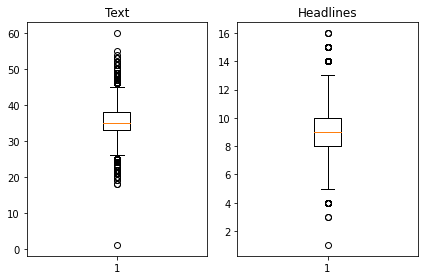

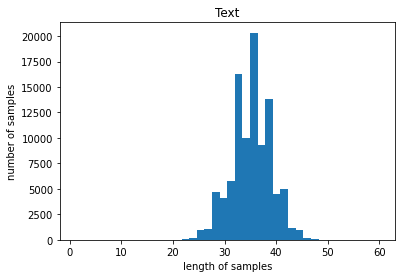

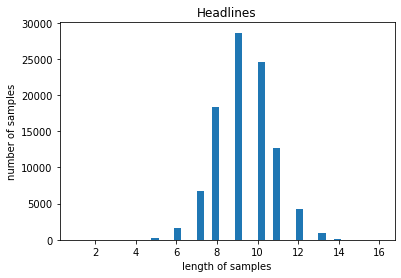

In [44]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위에서부터 차례대로 그래프는 각각 실제 텍스트와 헤드라인의 길이 분포, 실제 텍스트 샘플 길이별 개수, 헤드라인 샘플 길이별 개수를 나타내고 있어요.

Text의 경우 최소 길이가 1, 최대 길이가 60이다. 
하지만 평균 길이는 35로 시각화된 그래프로 봤을 때는 대체적으로는 50 내외의 길이를 가진다는 것을 확인

Headlines 경우 최소 길이가 1, 최대 길이가 16, 그리고 평균 길이가 9로 Text에 비해 상대적으로 길이가 매우 짧음. 
그래프로 봤을 때에도 대체적으로 12이하의 길이를 가지고 있음.

이로부터 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 지정.

In [51]:
text_max_len = 45
summary_max_len = 12

In [52]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

이렇게 만든 함수를 Text와 Summary에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있겠죠.

In [53]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


각각 45과 12로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제함

In [54]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)] 
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)] 

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96871


### 시작 토큰과 종료 토큰 추가하기

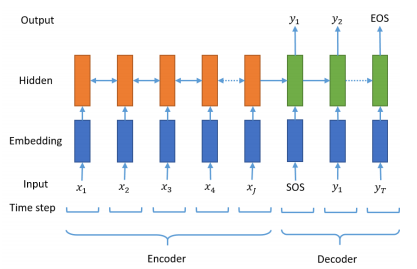content img
[시작 토큰 SOS와 종료 토큰 EOS는 각각 start of a sequence와 end of a sequence를 나타낸다]
https://arxiv.org/pdf/1812.02303.pdf

seq2seq 훈련을 위해, 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가
- 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가
- 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target으로 지정 
- 두 개의 문장 모두 headlines 열로부터 생성

In [55]:
# headline(요약) 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


---

In [56]:
# 전처리 완료 된 데이터를 저장
# data.to_pickle('./news_data_preprocessed.pkl')

In [57]:
# 중간에 세션이 끊길 경우, 전처리 데이터를 불러와서 사용한다.
data = pd.read_pickle('./news_data_preprocessed.pkl')
data

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
...,...,...,...,...
98396,crpf jawan axed to death by maoists in chhatti...,crpf jawan tuesday axed death sharp edged weap...,sostoken crpf jawan axed to death by maoists i...,crpf jawan axed to death by maoists in chhatti...
98397,first song from sonakshi sinha noor titled uff...,uff yeh first song sonakshi sinha starrer upco...,sostoken first song from sonakshi sinha noor t...,first song from sonakshi sinha noor titled uff...
98398,the matrix film to get reboot reports,according reports new version science fiction ...,sostoken the matrix film to get reboot reports,the matrix film to get reboot reports eostoken
98399,snoop dogg aims gun at clown dressed as trump ...,new music video shows rapper snoop dogg aiming...,sostoken snoop dogg aims gun at clown dressed ...,snoop dogg aims gun at clown dressed as trump ...


---

인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

In [58]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

훈련 데이터와 테스트 데이터를 분리

- encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 생성

In [60]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[45483 89875 46578 ... 93077 51765 44588]


- 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 샘플을 섞기

In [61]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
- 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의

In [62]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19374


이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분할게요.
:표시의 위치에 주의해 주세요.

In [63]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


훈련 데이터와 테스트 데이터가 각각 77,497개와 19,374로 잘 분리되었음.

### 단어 집합(vocabulary) 만들기 및 정수 인코딩

<span style="color:blue">**Keras의 토크나이저를 사용하여 단어 집합 만들기**</span>

In [66]:
from tensorflow.keras.preprocessing.text import Tokenizer

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

- 각 단어에 고유한 정수가 부여되었고, src_tokenizer.word_index에 저장되어 있음.   <span style="color:blue">빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행.</span>

- 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 *얼만큼의 비중을 차지하는지* 확인.

<span style="color:blue">src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있다.

In [67]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69157
등장 빈도가 6번 이하인 희귀 단어의 수: 47177
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21980
단어 집합에서 희귀 단어의 비율: 68.21724481975794
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.521350880116969


In [68]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행. 
<span style="color:blue"> 현재 단어 집합의 크기를 20,000으로 제한했으니까 이제 20,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.

In [69]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1624, 49, 2329, 2974, 363, 1330, 4158, 9962, 255, 26, 52, 1419, 1040, 144, 1279, 9963, 2315, 55, 1047, 144, 43, 12082, 529, 2989, 1770, 15262, 4199, 12447, 1295, 1047, 255, 1368, 1624, 96, 386, 1420, 49, 2974], [25, 752, 586, 1635, 4502, 3003, 1686, 193, 10390, 3646, 372, 1583, 148, 477, 1067, 12, 5008, 2870, 477, 264, 179, 25, 752, 671, 25, 8063, 1235, 1525, 1554, 165, 165, 3531, 325, 1345, 477], [428, 120, 6626, 4874, 1, 1647, 123, 335, 208, 729, 1636, 6485, 24, 6193, 869, 6193, 4533, 29, 133, 4874, 40, 428, 3083, 1444, 1464, 335, 6485, 2187, 1464, 102, 5614, 69, 1935, 1510, 3]]


headlines 데이터에 대해서도 동일한 작업을 수행.
- 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산

In [70]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

<span style="color:blue"> 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지</span> 확인.


In [71]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29967
등장 빈도가 5번 이하인 희귀 단어의 수: 19628
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10339
단어 집합에서 희귀 단어의 비율: 65.49871525344545
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.72365200398884


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 65%를 차지.   
하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 4.72%밖에 되지 않아, 제거.    

In [72]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 684, 3135, 1609, 1416, 14, 530, 15, 5568, 1561], [1, 995, 372, 240, 14, 1958, 5569, 219, 241, 7206], [1, 192, 81, 21, 100, 4933, 377, 142, 229, 4934, 1250, 67], [1, 7637, 472, 20, 162, 110, 71], [1, 691, 4099, 3757, 7638, 10, 178, 438]]
target
decoder  [[684, 3135, 1609, 1416, 14, 530, 15, 5568, 1561, 2], [995, 372, 240, 14, 1958, 5569, 219, 241, 7206, 2], [192, 81, 21, 100, 4933, 377, 142, 229, 4934, 1250, 67, 2], [7637, 472, 20, 162, 110, 71, 2], [691, 4099, 3757, 7638, 10, 178, 438, 2]]


빈도수가 낮아 제거되어 실제 데이터가 없는 샘플 삭제처리

In [73]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77496
훈련 레이블의 개수 : 77496
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


훈련 데이터와 테스트 데이터 모두 일정량의 샘플들이 제거된 것을 확인할 수 있어요. 이제 거의 다 왔어요.

### 패딩하기

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요. 아까 정해두었던 최대 길이로 패딩 해 줄 거에요. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [75]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
- 어텐션 메커니즘을 사용한 seq2seq를 설계

In [76]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


In [77]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일해요. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 해요.

디코더의 출력층을 설계해볼게요.

In [78]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

### 어텐션 메커니즘

In [79]:
attn_layer = AdditiveAttention(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있어요.

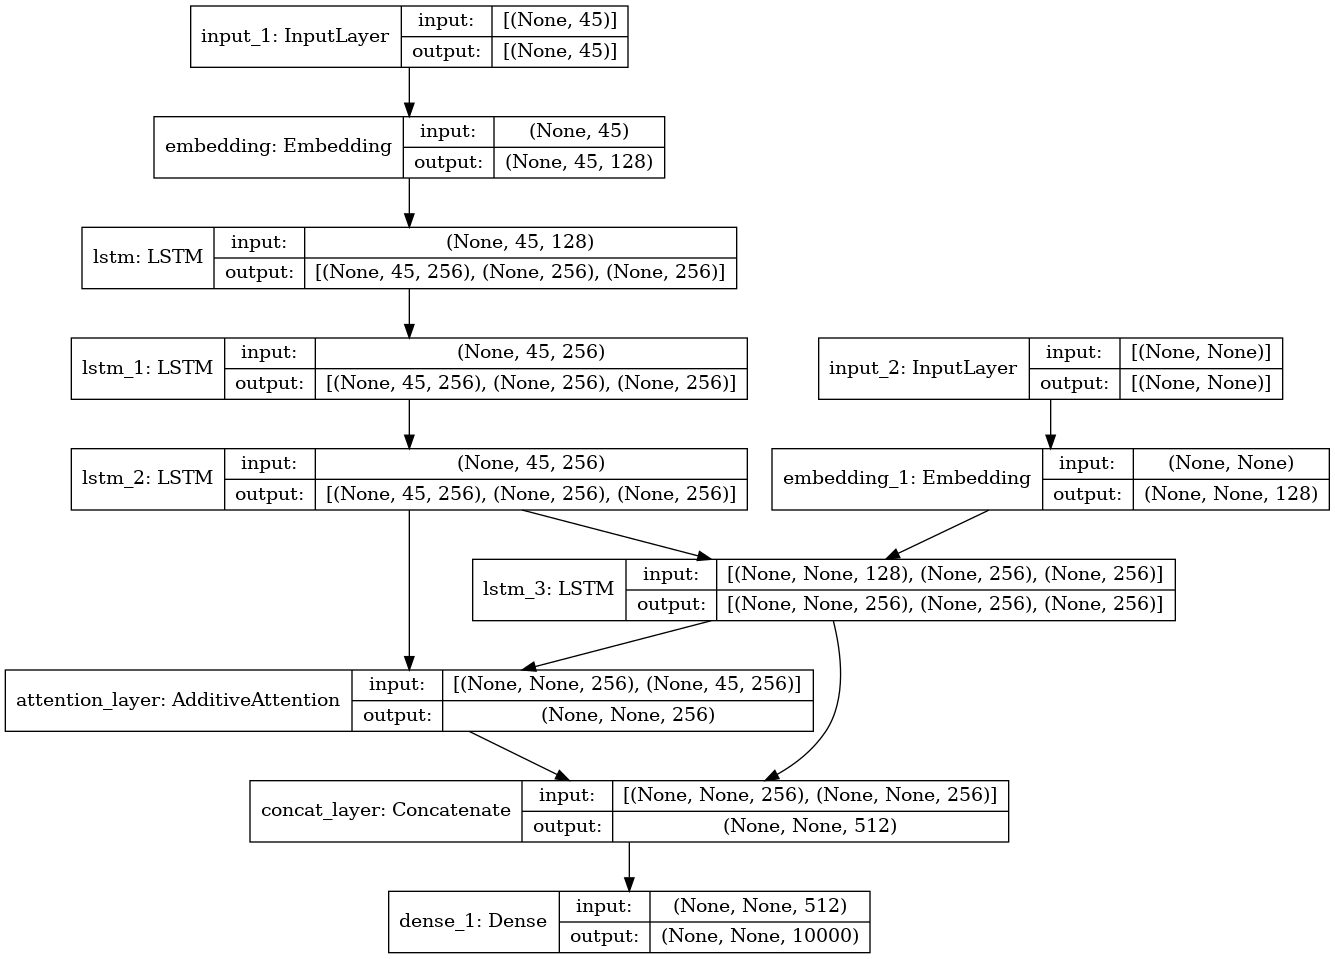

In [81]:
from tensorflow import keras

# 완성된 모델의 개념도 확인
keras.utils.plot_model(model, show_shapes=True)

- 왼쪽 위의 3개의 LSTM(input_3에서 lstm_6)까지 Encoder에 해당
- 오른쪽의 input_4부터 lstm_7까지가 Decoder에 해당하며, Decoder의 임베딩과 Encoder의 cell_state, hidden_state를 활용해서 계산된 값을 Encoder와 AdditiveAttention(Badanauh Attention)을 활용하여 최종적으로 Concatenate를 하고, Dense layer를 통해서 다음에 나올 토큰의 최종 확률 결과를 도출합니다.

## 모델 훈련하기
설계한 모델을 가지고 훈련을 진행해볼게요.

In [83]:
import os

In [85]:
%%time
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

checkpoint_filepath = os.getcwd() + './ckpt/headlines_checkpoint.model.keras'
# print(checkpoint_filepath)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
        #   batch_size=256,
          batch_size=2048, 
          callbacks=[es, model_checkpoint_callback], epochs=50)


Epoch 1/50
38/38 [==============================] - 33s 729ms/step - loss: 6.0153 - val_loss: 5.7663
Epoch 2/50
38/38 [==============================] - 28s 728ms/step - loss: 5.7078 - val_loss: 5.5736
Epoch 3/50
38/38 [==============================] - 28s 744ms/step - loss: 5.5347 - val_loss: 5.3907
Epoch 4/50
38/38 [==============================] - 28s 728ms/step - loss: 5.3700 - val_loss: 5.2672
Epoch 5/50
38/38 [==============================] - 28s 733ms/step - loss: 5.2534 - val_loss: 5.1689
Epoch 6/50
38/38 [==============================] - 28s 738ms/step - loss: 5.1368 - val_loss: 5.0649
Epoch 7/50
38/38 [==============================] - 28s 736ms/step - loss: 5.0194 - val_loss: 4.9721
Epoch 8/50
38/38 [==============================] - 28s 733ms/step - loss: 4.9145 - val_loss: 4.9001
Epoch 9/50
38/38 [==============================] - 28s 733ms/step - loss: 4.8151 - val_loss: 4.8006
Epoch 10/50
38/38 [==============================] - 28s 740ms/step - loss: 4.7231 - val_lo

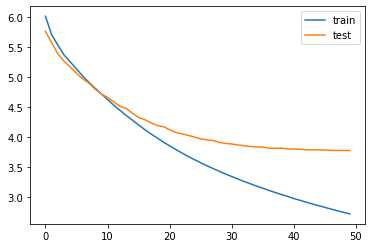

In [86]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

10분간 돌았고, Early stop을 적용했지만 50epoch을 다 돌았다. 확실한 Saturation을 위해서 50번 더 돌려봐야 할 것 같다.

In [87]:
# 모델 체크포인트 저장
model.save('saved_model/my_headlines_model')

INFO:tensorflow:Assets written to: saved_model/my_headlines_model/assets


INFO:tensorflow:Assets written to: saved_model/my_headlines_model/assets


In [88]:
# 50에폭 추가로 학습 진행하기
new_model = keras.models.load_model('saved_model/my_headlines_model')
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [89]:
history = new_model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
        #   batch_size=256,
          batch_size=2048, 
          callbacks=[es, model_checkpoint_callback], epochs=50)

Epoch 1/50
38/38 [==============================] - 34s 778ms/step - loss: 2.7403 - val_loss: 3.7780
Epoch 2/50
38/38 [==============================] - 28s 745ms/step - loss: 2.6726 - val_loss: 3.7745
Epoch 3/50
38/38 [==============================] - 28s 731ms/step - loss: 2.6466 - val_loss: 3.7821
Epoch 4/50
38/38 [==============================] - 28s 736ms/step - loss: 2.6215 - val_loss: 3.7806
Epoch 5/50
38/38 [==============================] - 28s 743ms/step - loss: 2.5968 - val_loss: 3.7822
Epoch 6/50
38/38 [==============================] - 28s 738ms/step - loss: 2.5732 - val_loss: 3.7874
Epoch 7/50
38/38 [==============================] - 28s 734ms/step - loss: 2.5504 - val_loss: 3.7861
Epoch 8/50
38/38 [==============================] - 28s 737ms/step - loss: 2.5280 - val_loss: 3.7873
Epoch 9/50
38/38 [==============================] - 28s 738ms/step - loss: 2.5079 - val_loss: 3.7934
Epoch 10/50
38/38 [==============================] - 28s 736ms/step - loss: 2.4853 - val_lo

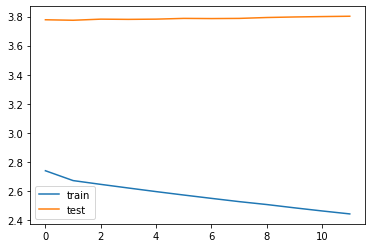

In [90]:
# 12에폭 추가 학습 후 플롯
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- 추가학습이 된 것이 점점 Overfit이 되는 경향을 확인.
- val_loss기준으로 1.94정도가 되는 에폭이 적절한 성능에 해당할 것 같다.

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

## 인퍼런스 모델 구현하기

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를   
<span style="color:blue"> 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비</span>해 둡니다.

In [91]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [92]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [93]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))

attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input]) # 2개 입력 시 : query, value = key
# decoder의 hidden상태가 key, val로 사용되고, 출력값이 query로 사용
# Additive attention : 
# Inputs are a list with 2 or 3 elements:
# A query tensor of shape (batch_size, Tq, dim).
# A value tensor of shape (batch_size, Tv, dim).
# A optional "key" tensor of shape (batch_size, Tv, dim). If none supplied, value will be used as key.

decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf]) 

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], # 4개의 입력
    [decoder_outputs2] + [state_h2, state_c2]) #3개의 output


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어주세요.

In [94]:
# 추론
def decode_sequence(input_seq):
    # 1. 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
     # <SOS>에 해당하는 토큰 생성 - 디코더에 입력하려고
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken'] # 토큰정보(1)을 입력 - 디코더가 1을 인식하여 문장을 계속해서 출력하게

    # eos token 발견 시 조건 저장용
    stop_condition = False
    # 토큰 정보를 기록
    decoded_sentence = ''
    
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복
        # 토큰값이 저장된 target_seq,과 인코더에 넣어서 나온 대표정보 값을 디코더에 넣어서 결과값(softmax)를 도출한다.
        # h, c -> 다음 예측에 사용할 값들
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) 
        # output_tokens에서 가장 확률이 높은 것의 index를 추출해서
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        # 단어로 변환한다.
        sampled_token = tar_index_to_word[sampled_token_index]
        
        # 변환한 토큰이 eos가 아니면 반환문자에 추가 해 준다.
        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 '최대 길이를 넘으면' 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트 (디코더의 개별 결과를 출력하기 위한 임시변수?)
        target_seq = np.zeros((1,1))

        # 다음 예측을 위해 활용
        target_seq[0, 0] = sampled_token_index
        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [95]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
# 1 : sostoken, 2 : eostoken을 확인

def seq2summary(input_seq):
    temp = ''
    for i in input_seq : 
        if (i>2):
            temp = temp + tar_index_to_word[i] + ' '

    return temp

테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보세요.

In [96]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : liu china recently proposed girlfriend meteorite claims bought around lakh meteorite reportedly weighed ton hidden red cover square revealed friends girlfriend said yes liu stated space rock stable enduring marriage 
실제 요약 : man proposes to girlfriend with meteorite worth lakh 
예측 요약 :  star wars explodes in the sky was sold for cr


원문 : union home minister rajnath singh sunday said talks pakistan stops exporting terrorists india alleging pakistan continuing attempts destabilise india sending terrorists violating singh claimed india emerged powerful country power threaten sovereignty 
실제 요약 : talks with pak till it stops terror aid rajnath 
예측 요약 :  india not our bullet to stop terrorism rajnath


원문 : eiffel tower paris soon get bullet proof glass wall along base bid improve security around monument glass wall cost million officials said comes wake several terror incidents paris past two years killed nearly people 
실제 요약 : eiffel tower to get bullet proof glass wall for security

예측 요약 :  prithvi shaw once smashed overs in balls in st odi match


원문 : belgian artist chained block marble show burden history artists cannot escape ate slept chained worked away stone failed free cut loose days said carry burden could free 
실제 요약 : artist self for days to show burden of history 
예측 요약 :  fashion designer encourages to perform in


원문 : woman west bengal hooghly district accidentally shot daughter gave pistol mistaking toy police said woman found loaded pistol garden house given daughter play daughter fired pistol shot mother back 
실제 요약 : woman gives daughter pistol mistaking it for toy gets shot 
예측 요약 :  man kills himself after being shot at home in us


원문 : union minister animal rights activist maneka gandhi authored manual standard operating procedures running cow shelters book exposes malpractices owners shelters provides tips making shelters financially gandhi plans request government departments agencies adopt manual 
실제 요약 : maneka gandhi manual for cow pro

예측 요약 :  india has to be lodged in india sushma swaraj


원문 : taxiforsure co founder radhakrishna led knowledge sharing startup raised crore series round funding led chinese investor shunwei capital startups existing investors accel india blume ventures also participated round app based local language question answer platform indians voice text capabilities 
실제 요약 : founder knowledge sharing app gets cr 
예측 요약 :  co founder invests in startup funding


원문 : average data rate per gb june plunged per gb december last year union telecom minister manoj sinha informed parliament wednesday said average outgoing call tariff dropped paise per minute june december period 
실제 요약 : cost of data has fallen to gb govt 
예측 요약 :  bse to spend crore on day of year


원문 : tesla developed new hardware suite called hw computing power reportedly help achieve goal self driving cars case current system proves inadequate tesla spokesperson confirmed new model vehicles hardware last year elon musk claimed fut

### Beam Search

- Greedy Decoding (해당 시점에서 가장 확률이 높은 후보를 선택)의 단점을 극복하기 위함
- 누적 확률이 높은 순으로 상위 k개를 뽑음.
- EOS를 만날 때 후보에 오르게 되고, 빔이 K개가 될 때까지 반복

In [109]:
# BeamSearch Sampler 정의
beam_search_scorer = keras_nlp.samplers.BeamSearch(
    decoder_model,
    max_length=summary_max_len,
    num_beams=3,
    eos_token_id=tar_word_to_index['eostoken'],
    pad_token_id=tar_word_to_index['padtoken']
)

def decode_sequence_beam_search(input_seq):
    # 1. 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # 디코더 입력으로 사용할 초기 시퀀스 준비 (start token)
    start_token = tar_word_to_index['sostoken']
    initial_input = np.array([[start_token]])
    
    # Beam Search로 디코딩 수행
    decoded_tokens = beam_search_scorer(initial_input, initial_state=[e_out, e_h, e_c])
    
    # 인덱스를 단어로 변환
    decoded_sentence = ' '.join([tar_index_to_word[token] for token in decoded_tokens if token not in [tar_word_to_index['sostoken'], tar_word_to_index['eostoken']]])
    
    return decoded_sentence

NameError: name 'keras_nlp' is not defined

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence_beam_search(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

- 버전 문제로 설치가 잘 되지않아서 시도해보지 못하였다.

## Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

## Summa의 summarize를 사용하여 추출적 요약을 해보세요.

프로젝트의 데이터에 적용을 해 봤는데, 요약 결과가 나오지 않았다. 찾아보니, 텍스트가 짧으면 잘 되지 않는다고 함.

In [125]:
from summa.summarizer import summarize

for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
#     print(seq2text(encoder_input_test[i]))
    print("Summa 예측 요약 :", summarize(seq2text(encoder_input_test[i]), ratio=0.2))
    print("\n")

원문 : liu china recently proposed girlfriend meteorite claims bought around lakh meteorite reportedly weighed ton hidden red cover square revealed friends girlfriend said yes liu stated space rock stable enduring marriage 
실제 요약 : man proposes to girlfriend with meteorite worth lakh 
Summa 예측 요약 : 


원문 : union home minister rajnath singh sunday said talks pakistan stops exporting terrorists india alleging pakistan continuing attempts destabilise india sending terrorists violating singh claimed india emerged powerful country power threaten sovereignty 
실제 요약 : talks with pak till it stops terror aid rajnath 
Summa 예측 요약 : 


원문 : eiffel tower paris soon get bullet proof glass wall along base bid improve security around monument glass wall cost million officials said comes wake several terror incidents paris past two years killed nearly people 
실제 요약 : eiffel tower to get bullet proof glass wall for security 
Summa 예측 요약 : 


원문 : directors cab hailing startup uber planning vote tuesday 

### 견해 :
- 잘 되는지는 모르겠는데, 루브릭에서 시도해보라고 되어 있어서 시도해보았고, 안 나와서 아쉽다..

In [120]:
text='''
Always get the best performance for your models. In our benchmarks, we found that JAX typically delivers the best training and inference performance on GPU, TPU, and CPU – but results vary from model to model, as non-XLA TensorFlow is occasionally faster on GPU. The ability to dynamically select the backend that will deliver the best performance for your model without having to change anything to your code means you're always guaranteed to train and serve with the highest achievable efficiency.
Maximize available ecosystem surface for your models. Any Keras model can be instantiated as a PyTorch Module, can be exported as a TensorFlow SavedModel, or can be instantiated as a stateless JAX function. That means that you can use your Keras models with PyTorch ecosystem packages, with the full range of TensorFlow deployment & production tools, and with JAX large-scale TPU training infrastructure. Write one model.py using Keras APIs, and get access to everything the ML world has to offer.
Maximize distribution for your open-source model releases. Want to release a pretrained model? Want as many people as possible to be able to use it? If you implement it in pure TensorFlow or PyTorch, it will be usable by roughly half of the market. If you implement it in Keras, it is instantly usable by anyone regardless of their framework of choice (even if they're not Keras users). Twice the impact at no added development cost.
Use data pipelines from any source. The Keras fit()/evaluate()/predict() routines are compatible with tf.data.Dataset objects, with PyTorch DataLoader objects, with NumPy arrays, Pandas dataframes – regardless of the backend you're using. You can train a Keras + TensorFlow model on a PyTorch DataLoader or train a Keras + PyTorch model on a tf.data.Dataset.

'''
summarize(text)

'Any Keras model can be instantiated as a PyTorch Module, can be exported as a TensorFlow SavedModel, or can be instantiated as a stateless JAX function.\nThat means that you can use your Keras models with PyTorch ecosystem packages, with the full range of TensorFlow deployment & production tools, and with JAX large-scale TPU training infrastructure.\nYou can train a Keras + TensorFlow model on a PyTorch DataLoader or train a Keras + PyTorch model on a tf.data.Dataset.'

In [133]:
text_enc = src_tokenizer.texts_to_sequences([text]) 
print(text_enc)
decode_sequence(text_enc)

[[585, 123, 293, 1004, 2443, 82, 12197, 8228, 293, 965, 1004, 1182, 626, 626, 408, 19052, 3313, 2931, 4705, 2457, 293, 1004, 626, 193, 512, 1190, 1432, 1940, 585, 9137, 435, 1892, 294, 7230, 930, 5964, 1841, 2443, 626, 7261, 12597, 2413, 1940, 231, 2443, 5964, 5000, 729, 1569, 8237, 988, 4449, 1222, 2496, 965, 1966, 3030, 17, 626, 147, 123, 827, 1606, 12424, 19, 842, 3501, 248, 1706, 626, 8873, 291, 217, 626, 291, 198, 10, 1058, 684, 231, 3655, 6161, 4173, 584, 380, 3655, 11732, 974, 10800, 6474, 2109, 208, 107, 1543, 1765, 4, 448, 576, 231, 140, 1706, 2444, 11027, 6061, 12106, 140, 3617, 3617, 10800, 147, 435, 626, 435, 626, 140]]


' malala may make new songs to promote malala'

- 이상하게 나오는데, 뭔가 잘못 적용한게 아닌가 싶다... 오히려 길어질 때는 summa(Extractive)요약이 더 잘 나오는 것 같다.

문법완성의 측면에서는 추상적 요약이 좀 더 우수하나, 핵심단어를 포함하는 면에서는 추출적 요약이 더 잘 반영하는 것 같다. 아쉬운 점은 추출적 요약으로 사용된 summa의 경우 너무 짧은 문단은 아무것도 반환하지 못한다는 것이었다.

# 오늘의 회고

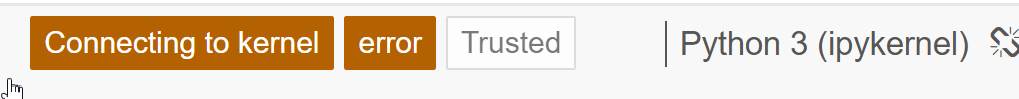

(20240613, 16:20)모델 설계 진행 중 원인 불명의 커널 다운이 발생, 또다시 텍스트 전처리를 해야함 ^^

### 디스코드에 남겼던 TIL
요약을 위한 방법론으로 추출적, 그리고 추상적으로 요약하는 것을 접근할 수 있다는 것을 처음 알게 되었음.
기존에 알고있던 NLP task는 주로 Encoder단을 활용해서 하던 작업 위주였기 때문에, 새로워서 어렵기는 하지만 재미있게 학습할 수 있었다.

위 개선이 필요한 부분에 언급은 하였지만, 나 또한 이러한 위기상황에 대한 대처를 할 생각을 안했다는 것이 안일했다고 판단된다. 앞으로 좀 시간이 많이 소요되는 작업을 마주치면, 데이터든 모델 가중치든 무조건 저장 혹은 백업을 하는 습관을 들여야겠다. 